## Quantum Graph Reccurent Neural Network in Pennylane

In [10]:
# Starts by importing all of the necessary dependencies

import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.optimize import minimize
import random
import math
import networkx as nx
import seaborn
import timeit
import tensorflow as tf

### Introduction

In this Notebook, we will investigate the idea of a **quantum graph neural network**, which is the quantum analogue of a classical graph neural network. More specicically, the quantum neural network we will be investigating is a **recurrent** quantum graph neural network. We will disucss what makes this sublcass unique later in the Notebook, but for now, we will note that these QGRNNs are very useful for learning the dynamics of quantum systems that "live" on a graph.

### The Quantum Graph Neural Network

In recent years, the idea of a quantum graph neural network has been receving a lot of attention from the machine learning research community for its ability to learn representations of data that is inhernelty graph-theoretic in nature. More specifically, graph neural networks seek to learn a **representation** (a mapping of the data into a lower-dimensional vector space) of a given graph, with features assigned to nodes and edges, such that the each of the vectors in the learned representation preserves the overall topology of the graph.

We will attempt to modify the same task, but from a quantum computational perspective. Specifically, we want to define an ansatz that we can use for quantum machine learning tasks that are inherently graph-theoretic. From the original QGNN paper, the general QGNN ansatz is defined as:

<br>
$$U(\boldsymbol\gamma, \ \boldsymbol\theta) \ = \ \displaystyle\prod_{i \ = \ 1}^{P} \Bigg[ \displaystyle\prod_{j \ = \ 1}^{Q} e^{-i \gamma_{ij} H_{j}(\boldsymbol\theta) }\Bigg]$$
<br>

Where we have:

<br>
$$\hat{H}_{j}(\boldsymbol\theta) \ = \ \displaystyle\sum_{(a,b) \in E} \displaystyle\sum_{c} V_{jabc} \hat{A}_{a}^{jc} \otimes \hat{B}_{b}^{jc} \ + \ \displaystyle\sum_{v \in V} \displaystyle\sum_{d} W_{jvd} \hat{C}_{v}^{jd}$$
<br>

As you can see, this is the class of Hamiltonians that posses a direct mapping between interaction and bias terms, and the edges and vertices (repsectively) of some graph $G \ = \ (V, \ E)$. This form of the Hamiltonian is very general, and as a result, has a lot of indices. The subscripts on operators represent some operator acting on the $a$-th, $b$-th or $v$-th qubit, and the other parameters ($c$ and $d$) simply allow us to label each parameter/type of operator in each term of both sums. This ansatz is fairly general: all it essentially tells us is that the QGNN involves many layers of parametrized operators that act on qubits according to the structure of some graph.

### The Quantum Graph Recurrent Neural Network

Now that we have discussed what a general quantum graph neural network looks like, let's discuss what distinguishes a quantum graph RNN from its more general counterpart. With a graph RNN, we make one small change to the $\boldsymbol\gamma$ parameters. Specifically, we tie these parameters over temproal layers, meaning that each $\gamma_{ij}$ is only determined by the index $j$, and is the same across all values of $i$ (with some fixed $j$). As the paper explains, this is equivalent to how a classical recurrent neural network behaves, where parameters remain the same over layers of the neural network. Thus, we will have:

<br>
$$U_{\text{RNN}}(\gamma, \ \theta) \ = \ \displaystyle\prod_{i \ = \ 1}^{P} \Bigg[ \displaystyle\prod_{j \ = \ 1}^{Q} e^{-i \gamma_{j} H_{j}(\boldsymbol\theta) }\Bigg]$$
<br>

Now, the Trotter-Suzuki decomposition says that:

<br>
$$\exp \Bigg[ \displaystyle\sum_{n} A_n \Bigg] \ = \ \lim_{P \rightarrow \infty} \displaystyle\prod_{j \ = \ 1}^{P} \Bigg[ \displaystyle\prod_{n} e^{A_n / P} \Bigg]$$
<br>

Where finite $P \ \gg \ 1$ approximates the left-hand side of the equation. It isn't too difficult to see that the quantum graph RNN resembles the Trotter-Suzuki decomposition. More specifically, the quantum graph RNN can be thought of as the Trotterization of the time-evolution operator, for some Hamiltonian. Let us fix a time $T$. Let us also fix a parameter that controls the size of the Trotterization steps (essentially the $1/P$ in the above formula), which we call $\Delta$. This allows uas to keep the precision of our approximate time-evolution for different values of $T$ the same. Let us define:

<br>
$$\hat{H} \ = \ \displaystyle\sum_{q} \hat{H}_{q}(\boldsymbol\theta)$$
<br>

<br>

By using the Trotter-Suzuki decomposition defined above, we can see that the time-evolution operator for this particular Hamiltonian can be approximated as:

<br>
$$e^{-i T H} \ \approx \ \displaystyle\prod_{i \ = \ 1}^{T / \Delta} \Bigg[ \displaystyle\prod_{j \ = \ 1}^{Q} e^{-i \Delta H_{j}(\boldsymbol\theta)} \Bigg] \ = \ U_{\text{RNN}}(\Delta, \ \boldsymbol\theta)$$
<br>

Thus, time-evolution is just a case of the QGRNN ansatz. This suggests to us that this ansatz may be particularly useful for learning the dynamics of quantum systems. Let's say that we are given a set $\{|\Psi(t)\rangle\}_{t \in T}$ of low-energy states that have been evolved under some unknown Hamiltonian $H$, for a bunch of different times in the set $T$. Our goal is to determine the Hamiltonian of this system, given only this collection of states, and the "general model" by which our system evolves (Ising, Heisenberg, etc.). In theory, one doesn't have to know the "model" of the system, but our algorithm would require an absurd amount of gates, and a lot of quantum data, so we will stick to the simpler case.

#### The Hamiltonian as a Feature Representation

You may now be wondering: "how is this Hamiltonian learning a graph-theoretic problem, fit for a **graph** neural network?". It is actually very interesting to note that this process of learning the Hamiltonian is actually a form of graph representation learning. Specifically, the $ZZ$ terms of the Hamiltonian will encode exactly where the edges of our graph interactions are. In addition to this, if we consider the state collection of states $\{ |\Psi(t)\rangle \}$ to be the features associated with the graph, then we are able to determine all of these by simply "using" the Hamiltonian (all we have to do is evolve our fixed initial state forward in time by some time $t$). Thus, the Hamiltonian is exactly the node representation that describes the graph along with its features. In this paradigm, however, we are dealing with inherently quantum mechanical data/features. This means that the data can't always necessarily be assigned to one node (in the case of entanglement between nodes), and in many cases, computation required to prepare, store, and process this quantum data scales poorly. Thus, our quantum graph neural network is particularly well-suited to this task.

### The QGRNN Applied to an Ising Model

In this Notebook we are going to investigate an application of the QGRNN to learning the dynamics of a 4-qubit Ising model.

#### Initializing the Graph and Preparing the Target Hamiltonian

We can begin by defining some fixed values that will be used through out the simulation, as well as the device on which we will run our simulations:

In [11]:
# Initialize the device on which the simulation is run

qubit_number = 4
qubits = range(qubit_number)
vqe_dev = qml.device("default.qubit", wires=qubit_number)

We will begin by defining the graph on which our Ising model lives. We choose the graph to be the completely connected graph with $3$ nodes, denoted by $K^3$. This is more commonly known as a triangle. We can construct and visualize this graph using `networkx`:

Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]


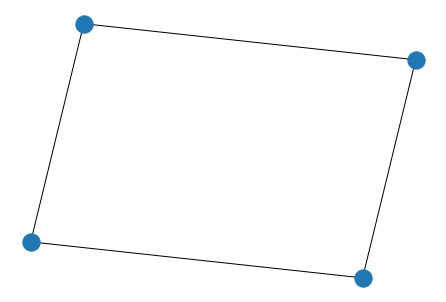

In [33]:
# Creates the graph structure of the quantum system

ising_graph = nx.Graph()
ising_graph.add_nodes_from(range(0, qubit_number))
ising_graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

# Plots the graph

nx.draw(ising_graph)

print("Edges: "+str(ising_graph.edges))

Now, let's define the Hamiltonian we will eventiually attempt to learn. There are two reasons for doing this. Firstly, we need to compare the preparred Hamiltonian to the targt Hamiltonian, to make sure that our toy example of the QGRNN actually works, and secondly, we have to prepare the quantum data that will be usd in training. In a real-world application of this algorithm, we would have access to a bunch of quantum data that we could feed into the neural network, but in this scenario, we have to generate the quantum data ourself. The only way to do this is to know the Hamiltonian (and thus, the dynamics) of our system. Our Ising model Hamiltonian will be of the form:

<br>
$$\hat{H} \ = \ \displaystyle\sum_{i, j} \alpha_{ij} Z_{i} Z_{j} \ + \ \displaystyle\sum_{i} \beta_{i} Z_{i} \ + \ \displaystyle\sum_{i} X_{i}$$
<br>

Where $\boldsymbol\alpha$ and $\boldsymbol\beta$ are the matrix and vector of interaction and bias parameters we are trying to learn, respectively. We will initialize $\boldsymbol\alpha$ and $\boldsymbol\beta$ randomly:

In [13]:
def create_params(graph):
    
    # Creates the interaction parameters
    interaction = [random.randint(-200, 200)/100 for i in range(0, len(graph.edges))]
    
    # Creates the bias parameters
    bias = [random.randint(-200, 200)/100 for i in range(0, qubit_number)]
    
    return [interaction, bias]

# Creates and prints the parameters for our simulation
matrix_params = create_params(ising_graph)
print("Target parameters: "+str(matrix_params))

Target parameters: [[0.42, -0.11, -0.36, -1.88], [0.04, 0.16, -0.84, 1.51]]


Wtih this knowledge, let's now construct the matrix representation of the Hamiltonian, in the $Z$-basis:

In [14]:
def create_hamiltonian_matrix(n, graph, params):
    
    # Defines Pauli matrices
    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))
    
    # Creates the interaction component of the Hamiltonian
    for count, i in enumerate(graph.edges):
        m = 1
        for j in range(0, n):
            if (i[0] == j or i[1] == j):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, params[0][count]*m)
    
    # Creates the "bias" component of the matrix
    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, params[1][i]*m)
    
    # Creates the X component of the matrix
    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    return matrix

# Defines and prints the matrix for our interaction graph and parameters
ham_matrix = create_hamiltonian_matrix(qubit_number, ising_graph, matrix_params)
print(ham_matrix)

[[-1.06000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -1.00000000e-01  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  5.10000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.00000000e+00 -1.46000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00

Since the Hamiltonian is the main object of interest in the quantum graph neural network, let's visualize it. We can write up a method that allows us to assign colours to the entires of an array, and prints out a nice-looking colour graph:

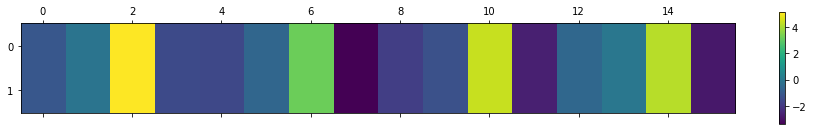

In [52]:
#Creates the grid visualization of the density matrices

def create_density_plot(data):

    array = np.array(data)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

create_density_plot([np.diag(ham_matrix), np.diag(ham_matrix)])

We can then visualize the **diagonal** elements of the Hamiltonian, as these are the only entries that correspond to trainable parameters (the off-diagonal elements remain fixed, so there is no point in visualizing them):

In [ ]:
# Visual display of the target Hamiltonian diagonal

create_density_plot([np.diag(ham_matrix), np.diag(ham_matrix)])

#### Preparing the Quantum Data with VQE

Now that we have prepared the target Hamiltonian, we can use it to prepare all of the necessary quantum data that we will use to train our QGRNN. As was discussed above, the data that will be fed into the neural network is a collection of time-evolved, low-energy quantum states corresponding to the target Hamiltonian. Thus, it follows that we must first prepare the low-energy states at $t \ = \ 0$, and evolve them forward in time to arbitrary times from $0$ to $T$. In order to prepare low energy states of the Hamiltonian, we will use VQE. Recall that the purpose of VQE is to find the ground energy state of a given Hamiltonian. We don't want to find the exact ground state of the Hamiltonian, as it's time evolution will just equate to the addition of a global phase.

<br>
$$U(t)|E_k\rangle \ = \ e^{-i H t / \hbar} |E_k\rangle \ = \ \displaystyle\sum_{n \ = \ 0}^{\infty} \Big( -\frac{i t}{\hbar} \Big)^n \frac{H^n |E_k\rangle}{n!} \ = \ \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{1}{n!} \Big( \frac{- i E_k t}{\hbar} \Big)^n |E_k\rangle \ = \ e^{i E_k t / \hbar} |E_k\rangle$$
<br>

Thus, this quantum data will be practically useless, as we are essentially just giving ourselves a bunch of copies of the exact same quantum state. Thus, instead of prearing the exact ground state, we wish to prepare a state $|\phi\rangle$ that is "close" to the ground state, $|\psi_0\rangle$ (meaning that $|\langle \phi | \psi_0 \rangle |^2$ is close to $1$). To do this, we will preform VQE, but we will use an ansataz that we know **won't converge exactly towards the ground state**.

For the specific example of the Hamiltonian we are considering in this tutorial, we have $ZZ$ interaction terms between qubits that share an edge on the graph. Thus, we know that it is likely that there will be some kind of entanglement between qubits in the ground state. We will then choose our ansatz such that the qubits remain **unentangled**. By only applying single-qubit gates, we ensure that each of the qubits remains completely uncorrelated from the others, thus making is so that the ground state can never be reached by our optimizer. The initial layer of our variational algorithms will be simply to create an even superposition over all basis states:

In [18]:
# Defines a method that creates an even superposition of basis states

def even_superposition(qubits):
    
    for i in qubits:
        qml.Hadamard(wires=i)

And the following layers will be alternating applications of $RZ$ and $RX$ gates:

In [19]:
# Method that prepares a low-energy state        
        
def decoupled_layer(param1, param2, qubits):
    
    # Applies a layer of RZ and RX gates
    for count, i in enumerate(qubits):
        
        qml.RZ(param1[count], wires=i)
        qml.RX(param2[count], wires=i)

We can then define our VQE ansatz as:

In [20]:
# Method that creates the decoupled VQE ansatz

def vqe_circuit(parameters, qubits, depth):
    
    even_superposition(qubits)
    
    for i in range(0, depth):
        decoupled_layer(parameters[0], parameters[1], qubits)

Finally, we can create a function and a QNode that allows us to run our VQE circuit:

In [21]:
# Defines the depth of our variational circuit
vqe_depth = 2

# Defines the circuit that we will use to perform VQE on our Hamiltonian
def create_circuit(params1, params2):
    
    vqe_circuit([params1, params2], qubits, vqe_depth)
    
    return qml.expval(qml.Hermitian(ham_matrix, wires=range(qubit_number)))

# Creates the corresponding QNode
qnode = qml.QNode(create_circuit, vqe_dev)

# Constructs a test case of our circuit
resulting_circuit = qnode([1, 1, 1, 1, 1], [1, 1, 1, 1, 1])
print(resulting_circuit)
print(qnode.draw())

-1.3399575738962546
 0: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──╭┤ ⟨H0⟩ 
 1: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──├┤ ⟨H0⟩ 
 2: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──├┤ ⟨H0⟩ 
 3: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──╰┤ ⟨H0⟩ 
H0 =
[[-1.06000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -1.00000000e-01  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  5.10000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

We have all of the code we need to optimize our quantum circuit, thus we create an optimizer and run it:

In [22]:
# Creates the cost function

def cost_function(params):

    return qnode(params[0:qubit_number], params[qubit_number:2*qubit_number])

# Creates the optimizer for VQE

optimizer = qml.AdamOptimizer(stepsize=0.8)

steps = 200
vqe_params = list([random.randint(-100, 100)/10 for i in range(0, 2*qubit_number)])

for i in range(0, steps):
    vqe_params = optimizer.step(cost_function, vqe_params)
    if (i%50 == 0):
        print("Cost Step "+str(i)+": "+str(cost_function(vqe_params)))

print(vqe_params)

Cost Step 0: -1.1246631821914508
Cost Step 50: -5.097305788738785
Cost Step 100: -5.20605098133167
Cost Step 150: -5.207131886658464
[-4.712710686673246, -4.789301113052475, -4.9705238128623765, 5.191001785669871, 6.306422387087022, -6.663046357510397, -6.932211052853649, -5.466566198442054]


Now, let's check to see if we generated a low-energy state. This will require us to find the ground state energy of the Hamiltonian:

In [23]:
# Finds the ground state energy of a Hamiltonian

def ground_state_energy(matrix):
    
    # Finds the eigenstates of the matrix
    val = np.linalg.eig(matrix)[0]
    
    # Returns the minimum eigenvalue
    return min(val)

ground_state = ground_state_energy(ham_matrix)
print(ground_state)

-5.332943284074904


This is pretty close to the energy value we found above with our decoupled VQE, so we can conclude that we have generated a low-energy state. With a good initial state, we can now prepare our collection of quantum data by evolving our initial state vector forward in time. We can do this exactly in Pennylane, using a custom unitary gate, which we define to be the time-evolution operator for our Ising model Hamiltonian, which we defined above:

In [24]:
# Creates an exact time-evolution unitary

def state_evolve(hamiltonian, qubits, time):

    U = scipy.linalg.expm(complex(0,-1)*hamiltonian*time)
    qml.QubitUnitary(U, wires=qubits)

#### Learning the Hamiltonian

This is all we need to prepare our quantum data. Now, let's turn our attention to the actual quantum graph neural network ansatz. Our goal is to learn $\hat{H}$ by findings the parameters $\boldsymbol\alpha$ and $\boldsymbol\beta$.

The idea behind this protocol is for the QGRNN ansatz, with some inputed parameters, to act like an effective time-evolution operator, under the Hamiltonian with our "guessed" parameters. We will then have this effective operator act upon the initial low-energy state prepared by our VQE process, $|\psi_0\rangle$. We will also prepare another register of qubits so that it contains one of the samples from our quantum data, $|\Psi(t)\rangle$. Finally, we will perform a [SWAP test](https://en.wikipedia.org/wiki/Swap_test) between the two registers, which allows us to compute the inner product between the states contained in the two registers. This will tell us how "similar" the two states are. We will finally calculate the average infidelity (one minus the average fidelity) for all of our quantum data, as shown below (we use this as our cost function):

<br>
$$\mathcal{L}(\Delta, \ \boldsymbol\theta) \ = \ 1 \ - \ \frac{1}{|T|} \displaystyle\sum_{t \ \in \ T} | \langle \Psi(t) | \ U_{\text{RNN}}(\Delta, \ \boldsymbol\theta) \ |\psi_0\rangle |^2$$
<br>

As the parameters of our learned Hamiltonian approach those of the true Hamiltonian ($\boldsymbol\alpha$ and $\boldsymbol\beta$), our QGRNN ansatz becomes a good approximation of the time-evolution operator under the true Hamiltonian. This means that the states in the two registers are essentially the same, and infidelity approaches $0$. Thus, as we minimize the cost function, we reconstruct the true Hamiltonian.

Here is a diagram explaining the general procedure of the algorithm:

<br>
<center>
    <img src="assets/qgrnn.png" style="width:800px;">
</center>
<br>

Our Ising Hamiltonian involves $ZZ$ gates, thus we need to write a method that allows us to construct $RZZ$ gates out of the standard gate set in Pennylane:

In [25]:
# Defines the RZZ gate, in terms of gates in the standard basis set

def RZZ(param, qubit1, qubit2):
    
    qml.CNOT(wires=[qubit1, qubit2])
    qml.RZ(param, wires=qubit2)
    qml.CNOT(wires=[qubit1, qubit2])

Where the implemented gate is equivalent to the $RZZ$ gate. With this, we can now write a function that implements one step of the Trotterized time evolution:

In [26]:
# Method that prepares a time-evolution layer

def qgrnn_layer(param1, param2, qubits, graph, trotter):
    
    # Applies a layer of coupling gates (based on the graph)
    for count, i in enumerate(graph.edges):
        RZZ(2*param1[count]*trotter, i[0], i[1])
    
    # Applies a layer of RZ gates
    for count, i in enumerate(qubits):
        qml.RZ(2*param2[count]*trotter, wires=i)
    
    # Applies a layer of RX gates
    for i in qubits:
        qml.RX(2*trotter, wires=i)

Finally, we will need to make use of the $SWAP$ test, to calculate the fidelity between the prepared quantum state and our quantum data. As it turns out, the inner product of the two states ends up simply being $\langle Z \rangle$, with respect to the ancilla qubit. When we perform a $SWAP$ test, we get:

<br>
$$\text{P}(\text{Ancilla} \ = \ 0) \ = \ \frac{1}{2} \ + \ \frac{1}{2} | \langle \psi | \phi \rangle |^2$$
<br>

Where $|\psi\rangle$ and $|\phi\rangle$ are the states contained in the two registers. We also have:

<br>
$$\langle Z \rangle \ = \ (1) \text{P}(\text{Ancilla} \ = \ 0) \ + \ (-1) \text{P}(\text{Ancilla} \ = \ 1) \ = \ \text{P}(\text{Ancilla} \ = \ 0) \ - \ \big(1 \ - \ \text{P}(\text{Ancilla} \ = \ 0)\big) \ = \ 2\text{P}(\text{Ancilla} \ = \ 0) \ - \ 1$$
<br>

So we have:

<br>
$$\text{P}(\text{Ancilla} \ = \ 0) \ = \ \frac{1}{2} \ + \ \frac{1}{2} \langle Z \rangle$$
<br>

Thus, from the first and the third equation, we get $\langle Z \rangle \ = \ |\langle \psi | \phi \rangle|^2$. We can write a function that performs this process:

In [27]:
# Implements the SWAP test between two qubit registers

def swap_test(control, register1, register2):
    
    qml.Hadamard(wires=control)
    for i in range(0, len(register1)):
        qml.CSWAP(wires=[int(control), register1[i], register2[i]])
    qml.Hadamard(wires=control)

From here, we can build our quantum circuit that corresponds to one execution of our QGRNN, for a given time step. First, let's define a new quantum device with $7$ qubits rather than $3$, as we will need registers for our neural network, and data-preparation, plus an extra qubit for the $SWAP$ test.

In [35]:
# Defines the new
qgrnn_dev = qml.device("default.qubit", wires=2*qubit_number+1)

We then define a few more fixed variables needed for our simulation. Here, we can define the two registers of qubits, the index of the ancilla qubit (for the $SWAP$ test), the size of the Trotterization steps, and a new graph of interations. It is important to note that we do not know the interaction structure (which qubits are "connected" by $ZZ$ interactions) of our model before we begin the simulation. Thus, we initialize our model in a more general structure than the square-shaped graph that we utilized at the beginning of this tutorial. We thus choose the most general graph of interactions for $4$ qubits, the complete graph $K^4$. We then hope that as our algorithm converges, it learn the structure of the graph by setting the parameters of edge $(0, \ 2)$ and $(1, \ 3)$ to $0$:

Edges: [(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


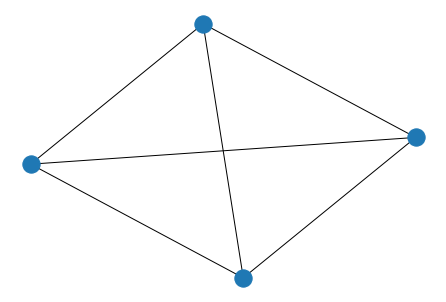

In [57]:
# Defines some fixed values

reg1 = list(range(qubit_number))
reg2 = list(range(qubit_number, 2*qubit_number))

control = 2*qubit_number
trotter_step = 0.01

# Defines the interaction graph for the new qubit system

new_ising_graph = nx.Graph()
new_ising_graph.add_nodes_from(range(qubit_number, 2*qubit_number))
new_ising_graph.add_edges_from([(4, 5), (5, 6), (6, 7), (4, 6), (7, 4), (5, 7)])

print("Edges: "+str(new_ising_graph.edges))
nx.draw(new_ising_graph)

Finally, we can implement the QGRNN ansatz, as we outlined above:

In [48]:
# Implements the quantum graph neural network for a given time step

def qgrnn(params1, params2, time):
    
    # Prepares the low energy state in the two qubit registers
    vqe_circuit([vqe_params[0:qubit_number], vqe_params[qubit_number:2*qubit_number]], reg1, vqe_depth)
    vqe_circuit([vqe_params[0:qubit_number], vqe_params[qubit_number:2*qubit_number]], reg2, vqe_depth)
    
    # Evolves the first qubit register with the time-evolution circuit
    state_evolve(ham_matrix, reg1, time.val)
    
    # Applies the time-evolution layers to the second qubit register
    depth = time.val/trotter_step
    for i in range(0, int(depth)):
        #qgrnn_layer(matrix_params[0], matrix_params[1], reg1, ising_graph, trotter_step)
        qgrnn_layer(params1, params2, reg2, new_ising_graph, trotter_step)
    
    # Applies the SWAP test between the registers
    swap_test(control, reg1, reg2)
    
    # Returns the results of the SWAP test
    return qml.expval(qml.PauliZ(control))

We are new tasked with constructing the cost function of our model. To evaluate the cost function, we simply have to choose a bunch of time steps at which we will execute of QGRNN. We begin by defining a few more values, along with our new QNode:

In [49]:
batch = 15 # The number of different times that will be used
max_time = 0.1  # The maximum value of time that can be utilized

# Defines the new QNode

qnode = qml.QNode(qgrnn, qgrnn_dev)

And then, we define the cost function:

In [50]:
# Defines the cost function

def cost_function(params):
     
    global iterations
    
    # Separates the parameter list
    weight_params = params[0:6]
    bias_params = params[6:10]
    
    # Samples times at which the QGRNN will be run
    times_sampled = [np.random.uniform() * max_time for i in range(0, batch)]
     
    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for i in times_sampled:
        result = qnode(weight_params, bias_params, i)
        total_cost += 1 - result
    
    # Prints the value of the cost function
    print("Cost at Step "+str(iterations)+": "+str((1 - total_cost / batch)._value)+" - "+str(params._value))
    iterations += 1
    
    return total_cost / batch

Finally, we execute the optimization method using the Adam optimizer.

In [51]:
# Defines the optimization method

iterations = 0

optimizer = qml.AdamOptimizer(stepsize=0.5)
steps = 100

qgrnn_params = list([random.randint(-20, 20)/10 for i in range(0, 10)])

# Executes the optimization method

for i in range(0, steps):
    qgrnn_params = optimizer.step(cost_function, qgrnn_params)

print(qgrnn_params)

Cost at Step 0: 0.9629573496827061 - [0.9, 1.8, 1.0, -1.7, -0.3, -0.4, 0.4, 0.8, -1.3, -2.0]
Cost at Step 1: 0.993835052565473 - [0.4000009965411841, 1.3000005543132656, 0.5000006158669671, -1.2000009386524224, 0.19999899649018815, -0.8999986212072486, 0.8999993860397126, 0.300000848999061, -0.8000022613142977, -1.5000028656507927]
Cost at Step 2: 0.9939453995294547 - [0.06235334253042357, 0.9592829527840567, 0.16074462644428672, -0.8598518592408866, 0.5380291797795091, -1.2423838861746246, 1.2391396677111335, -0.03911520054299733, -0.45967454451496215, -1.154717487315844]
Cost at Step 3: 0.990260242842246 - [-0.17922709407500012, 0.6916871082203568, -0.09337678207983391, -0.5977156950240843, 0.7800445031434454, -1.5245563987598685, 1.492109700498792, -0.2913697923618386, -0.19502261654612207, -0.8476531622825769]
Cost at Step 4: 0.9832212238814403 - [-0.3467453786124589, 0.48101094701888925, -0.2813222093165536, -0.3964125837251262, 0.9476732262118921, -1.7595474163732008, 1.678035919

Now, let's prepare the Hamiltonian corresponding to the learned parameters:

In [53]:
new_ham_matrix = create_hamiltonian_matrix(qubit_number, nx.complete_graph(qubit_number), [qgrnn_params[0:6], qgrnn_params[6:10]])
print(new_ham_matrix)

[[-1.38614954  1.          1.          0.          1.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 1.          0.00955861  0.          1.          0.          1.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.        ]
 [ 1.          0.          5.36582751  1.          0.          0.
   1.          0.          0.          0.          1.          0.
   0.          0.          0.          0.        ]
 [ 0.          1.          1.         -1.30603938  0.          0.
   0.          1.          0.          0.          0.          1.
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.         -1.78709138  1.
   1.          0.          0.          0.          0.          0.
   1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          1.         -0.39852963
   0.      

Finally, we can comapre the diagonal elements of the learned Hamiltonian (bottom row) to the those of the target Hamiltonian (top row):

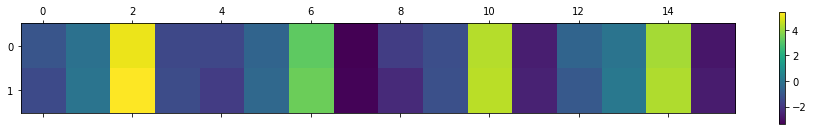

In [54]:
create_density_plot([np.diag(ham_matrix), np.diag(new_ham_matrix)])

The similarity of colours indicates that the QGRNN was able to learn the parameters to a very high degree accuracy!

### References

1. Verdon, G., McCourt, T., Luzhnica, E., Singh, V., Leichenauer, S., & Hidary, J. (2019). Quantum Graph Neural Networks. arXiv preprint [arXiv:1909.12264](https://arxiv.org/abs/1909.12264).